Twitter is a platform where millions of users worldwide share their daily thoughts, opinions, and experiences. The tweets shared on this social media platform express various emotions through their textual content. The goal of this project is to automatically identify the emotional tones - positive, negative, or neutral - conveyed by tweets posted by Twitter users, using machine learning and natural language processing (NLP) techniques. This analysis enables brands and individuals to better understand public perceptions and reactions, as well as to follow public opinion trends. Furthermore, the results of sentiment analysis provide valuable insights that can be used in strategic decision-making processes in areas such as crisis management, customer service, and product development. Especially in the rapid and dynamic flow of communication on Twitter, the instantaneous detection of emotional states plays a significant role in real-time data analysis.

## 1 | Importing Libraries

In [1]:
!pip install nltk
!pip install twython
!pip install textblob
!pip install wordcloud

In [2]:
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [3]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

## 2 | Adjusting Row Column Settings


In [4]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 3 | Loading Dataset


In [5]:
df=pd.read_csv("/content/drive/MyDrive/ML Projects/tweets_labeled.csv/tweets_labeled.csv")


In [6]:
df.head()


,tweet_id,tweet,date,label
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37+00:00,1
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18+00:00,1
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36+00:00,1
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47+00:00,1
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32+00:00,1


In [7]:
df.columns


Index(['tweet_id', 'tweet', 'date', 'label'], dtype='object')

In [8]:
df.shape


(12960, 4)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  12960 non-null  int64 
 1   tweet     12959 non-null  object
 2   date      12960 non-null  object
 3   label     12960 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 405.1+ KB


## 4 | Processing Date and Time Data


In [10]:
df["date"] = pd.to_datetime(df["date"])
df["date"] = df["date"].dt.tz_convert("Europe/Istanbul")
df['date'] = df['date'].dt.tz_localize(None)

In [11]:
df['month'] = df['date'].dt.month_name()
df['tweet'] = df['tweet'].str.lower()

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tweet_id  12960 non-null  int64         
 1   tweet     12959 non-null  object        
 2   date      12960 non-null  datetime64[ns]
 3   label     12960 non-null  int64         
 4   month     12960 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 506.4+ KB


In [13]:
# Creating the variable "seasons"
seasons = {'January': 'Winter',
           'February': 'Winter',
           'March': 'Spring',
           'April': 'Spring',
           'May': 'Spring',
           'June': 'Summer',
           'July': 'Summer',
           'August': 'Summer',
           'September': 'Autumn',
           'October': 'Autumn',
           'November': 'Autumn',
           'December': 'Winter'}

In [14]:
df['seasons'] = df['month'].map(seasons)

In [15]:
df.head()


,tweet_id,tweet,date,label,month,seasons
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,December,Winter
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,June,Summer
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,June,Summer
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,February,Winter
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,February,Winter


In [16]:
# Creation of the day variable
df["days"] = [date.strftime('%A') for date in df["date"]]

In [17]:
df["hour"] = df["date"].dt.hour


In [18]:
df.head()


,tweet_id,tweet,date,label,month,seasons,days,hour
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,December,Winter,Sunday,0
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,June,Summer,Thursday,0
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,June,Summer,Tuesday,0
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,February,Winter,Sunday,18
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,February,Winter,Sunday,23


In [19]:
df['4hour_interval'] = (df['hour'] // 2) * 2


In [20]:
df.head()


,tweet_id,tweet,date,label,month,seasons,days,hour,4hour_interval
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,December,Winter,Sunday,0,0
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,June,Summer,Thursday,0,0
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,June,Summer,Tuesday,0,0
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,February,Winter,Sunday,18,18
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,February,Winter,Sunday,23,22


In [21]:
interval = {0: '0-2',
            2: '2-4',
            4: '4-6',
            6: '6-8',
            8: '8-10',
            10: '10-12',
            12: '12-14',
            14: '14-16',
            16: '16-18',
            18: '18-20',
            20: '20-22',
            22: '22-24'
            }

In [22]:
df['4hour_interval'] = df['4hour_interval'].map(interval)


In [23]:
df.head()


,tweet_id,tweet,date,label,month,seasons,days,hour,4hour_interval
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,December,Winter,Sunday,0,0-2
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,June,Summer,Thursday,0,0-2
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,June,Summer,Tuesday,0,0-2
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,February,Winter,Sunday,18,18-20
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,February,Winter,Sunday,23,22-24


In [24]:
df["time_interval"] = df["4hour_interval"].replace({"0-2": "22-02",
                                                   "22-24": "22-02",
                                                   "2-4": "02-06",
                                                   "4-6": "02-06",
                                                   "6-8": "06-10",
                                                   "8-10": "06-10",
                                                   "10-12": "10-14",
                                                   "12-14": "10-14",
                                                   "14-16": "14-18",
                                                   "16-18": "14-18",
                                                   "18-20": "18-22",
                                                   "20-22": "18-22"})

In [25]:
df.head()


,tweet_id,tweet,date,label,month,seasons,days,hour,4hour_interval,time_interval
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,December,Winter,Sunday,0,0-2,22-02
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,June,Summer,Thursday,0,0-2,22-02
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,June,Summer,Tuesday,0,0-2,22-02
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,February,Winter,Sunday,18,18-20,18-22
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,February,Winter,Sunday,23,22-24,22-02


In [26]:
df.drop(["4hour_interval", "hour"], axis=1, inplace=True)


In [27]:
df.head()


,tweet_id,tweet,date,label,month,seasons,days,time_interval
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,December,Winter,Sunday,22-02
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,June,Summer,Thursday,22-02
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,June,Summer,Tuesday,22-02
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,February,Winter,Sunday,18-22
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,February,Winter,Sunday,22-02


In [28]:
label = {1: 'positive',
        -1: 'negative',
        0: 'neutral'
         }

In [29]:
df['label'] = df['label'].map(label)


In [30]:
df.head()


,tweet_id,tweet,date,label,month,seasons,days,time_interval
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,positive,December,Winter,Sunday,22-02
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,positive,June,Summer,Thursday,22-02
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,positive,June,Summer,Tuesday,22-02
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,positive,February,Winter,Sunday,18-22
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,positive,February,Winter,Sunday,22-02


In [31]:
def summary(dataframe, col_name, plot=False, save_plots=False):
    """
    Generate summary statistics and plots for a specified column in a pandas DataFrame
    focusing on negative tweets.

    Parameters:
    dataframe (pandas.DataFrame): A pandas DataFrame containing the text data.
    col_name (str): The name of the column to analyze.
    plot (bool): Whether to plot the distribution of the column.
    save_plots (bool): Whether to save the plots to files.

    Returns:
    None: This function only prints summary statistics and plots the results.
    """

    dataframe = dataframe.loc[dataframe["label"] == 'negative']
    count_series = dataframe[col_name].value_counts()
    ratio_series = 100 * count_series / len(dataframe)
    summary_df = pd.DataFrame({col_name: count_series, "Ratio": ratio_series})
    print(summary_df)
    print("---------------------------------------------")

    if plot:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=dataframe[col_name], data=dataframe, palette="viridis")
        ax.set_title(f"Distribution of {col_name.capitalize()} in Negative Tweets")
        ax.set_ylabel('Count')
        ax.set_xlabel(col_name.capitalize())


        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black',
                        xytext=(0, 5), textcoords='offset points')

        plt.xticks(rotation=45)
        plt.tight_layout()

        if save_plots:
            plt.savefig(f"{col_name}_distribution.png")

        plt.show()

               time_interval  Ratio
time_interval                      
22-02                   1181  40.67
18-22                    616  21.21
14-18                    359  12.36
10-14                    326  11.23
02-06                    261   8.99
06-10                    161   5.54
---------------------------------------------


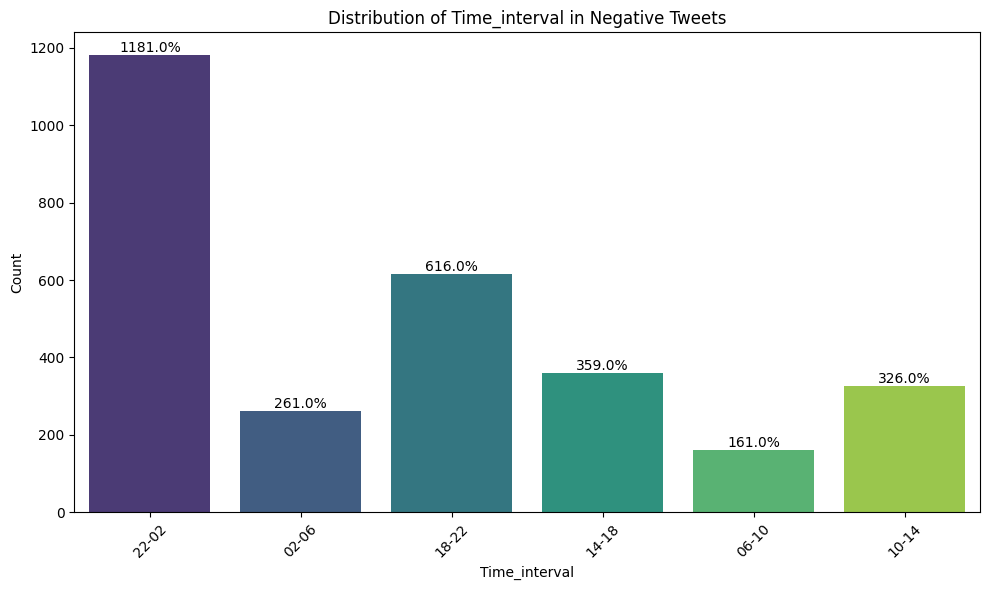

           days  Ratio
days                  
Tuesday     451  15.53
Monday      435  14.98
Friday      433  14.91
Sunday      417  14.36
Thursday    408  14.05
Wednesday   388  13.36
Saturday    372  12.81
---------------------------------------------


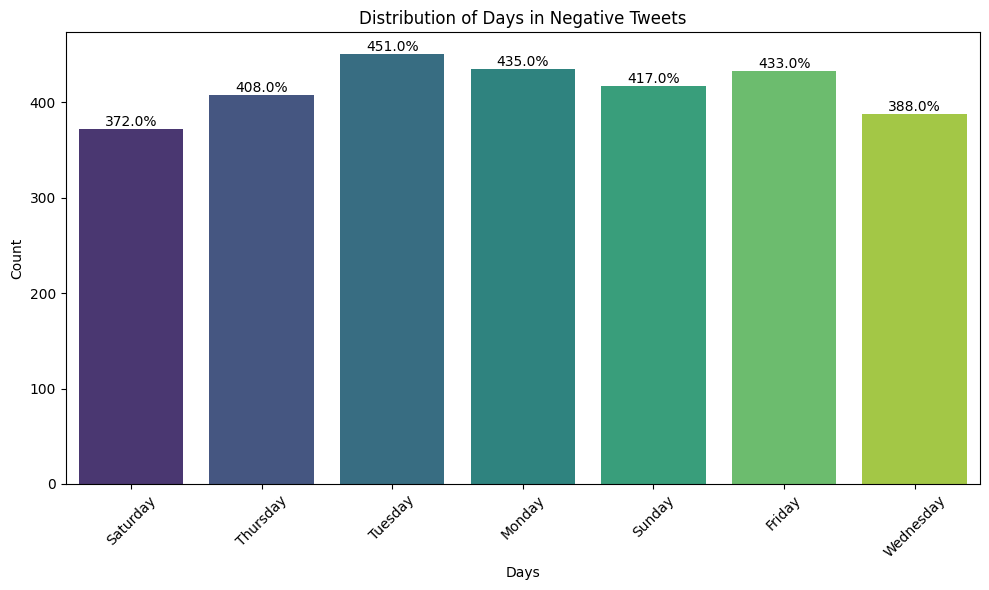

         seasons  Ratio
seasons                
Winter       999  34.40
Autumn       705  24.28
Summer       633  21.80
Spring       567  19.52
---------------------------------------------


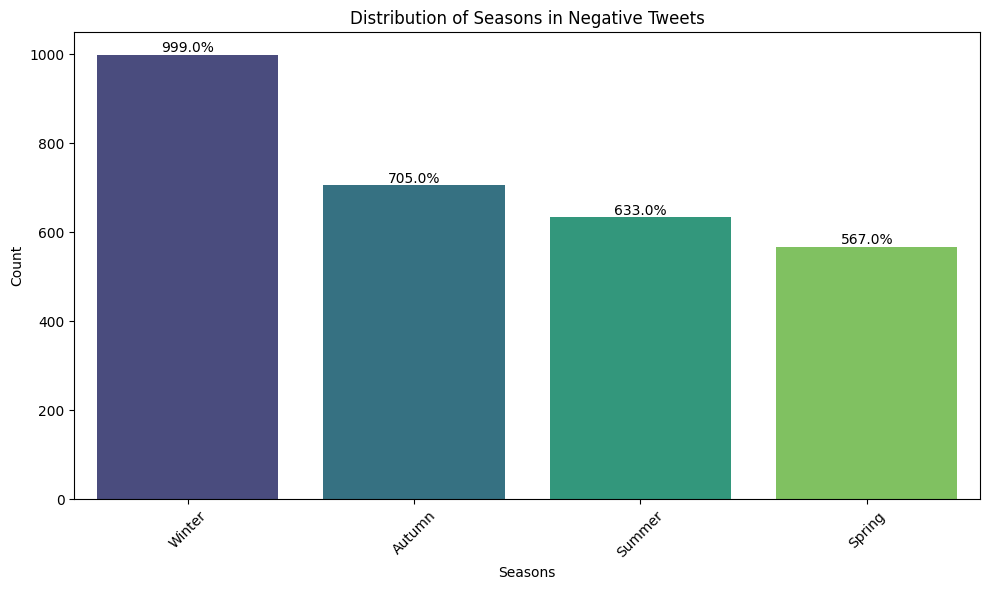

In [32]:
cols = ["time_interval", "days", "seasons"]
for col in cols:
    summary(df, col, plot=True, save_plots=True)


## 5 | Text Preprocessing


In [33]:
# Lowercases, Punctuation, Numbers and Newline Characters
def clean_text(text):
    """
    Clean and preprocess text data.

    This function performs several cleaning operations on text data:
    - Lowercases the text (Case Folding)
    - Removes punctuation
    - Removes numbers
    - Removes newline characters

    Parameters:
    text (pandas.Series): A pandas Series containing text data.

    Returns:
    pandas.Series: A pandas Series with cleaned text.
    """
    # Lowercasing (Case Folding)
    text = text.str.lower()
    # Removing punctuations, numbers, and newline characters
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    return text

In [34]:
df["tweet"] = clean_text(df["tweet"])


In [35]:
df["tweet"]


,tweet
0,berk ali kedim seni çok özledim ölmek için dah...
1,yani öylesine ciddiye alacaksın ki yaşamayı ye...
2,saçlarının gölgesindeölmek ne güzeldi
3,öyle güzel baktın ki gözlerimesevmek değil ölm...
4,sevmek biri için ölmek değil her şeye rağmen y...
...,...
12955,hafta içi her gün aaat ten sonra boynuma hiçbi...
12956,perşembe günleri gönüllü olarak staja gittiğim...
12957,insan mutlu olunca degil cok çalışınca tivik a...
12958,üniversiteyi yeni kazananlar ilk gün sabah de...


In [36]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
stop_words = stopwords.words('turkish')


In [38]:
# Stopwords
def remove_stopwords(text):
    """
    Remove stopwords from text data.

    This function filters out common stopwords from the text data.
    Stopwords are removed based on the NLTK's English stopwords list.

    Parameters:
    text (pandas.Series): A pandas Series containing text data.

    Returns:
    pandas.Series: A pandas Series with stopwords removed from the text.
    """
    # Removing stopwords
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word not in stop_words))
    return text

In [39]:
df["tweet"] = remove_stopwords(df["tweet"])


In [40]:
df["tweet"]


,tweet
0,berk ali kedim seni özledim ölmek küçücüktün s...
1,öylesine ciddiye alacaksın yaşamayı yetmişinde...
2,saçlarının gölgesindeölmek güzeldi
3,öyle güzel baktın gözlerimesevmek değil ölmek ...
4,sevmek ölmek değil şeye rağmen yaşayabilmek miş
...,...
12955,hafta içi gün aaat ten sonra boynuma hiçbir şe...
12956,perşembe günleri gönüllü olarak staja gittiğim...
12957,insan mutlu olunca degil cok çalışınca tivik a...
12958,üniversiteyi yeni kazananlar ilk gün sabah der...


In [41]:
# Rare Words and Frequent Words
def remove_rare_words(df, column_name, n_rare_words=1000):
    """
    Remove rare words from a specified column in a pandas DataFrame.

    This function identifies and removes the least frequently occurring words
    in the text data. It is useful for removing rare words that might not contribute
    significantly to the analysis or modeling.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column in the DataFrame to clean.
    n_rare_words (int): The number of least frequent words to remove.

    Returns:
    pandas.DataFrame: A DataFrame with rare words removed from the specified column.
    """
    # Identifying the rare words
    freq = pd.Series(' '.join(df[column_name]).split()).value_counts()
    rare_words = freq[-n_rare_words:]

    # Removing the rare words
    df[column_name] = df[column_name].apply(lambda x: " ".join(word for word in x.split() if word not in rare_words))
    return df

In [42]:
df = remove_rare_words(df, 'tweet', 1000)


In [43]:
df["tweet"]


,tweet
0,berk ali kedim seni özledim ölmek küçücüktün s...
1,öylesine ciddiye alacaksın yaşamayı yetmişinde...
2,saçlarının gölgesindeölmek güzeldi
3,öyle güzel baktın gözlerimesevmek değil ölmek ...
4,sevmek ölmek değil şeye rağmen yaşayabilmek miş
...,...
12955,hafta içi gün aaat ten sonra boynuma hiçbir şe...
12956,perşembe günleri gönüllü olarak staja gittiğim...
12957,insan mutlu olunca degil cok çalışınca tivik a...
12958,üniversiteyi yeni kazananlar ilk gün sabah der...


In [44]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
from textblob import TextBlob

df["tokenized_tweet"] = df["tweet"].astype(str).apply(lambda x: TextBlob(x).raw.split())

In [46]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
# Lemmatization

def apply_lemmatization(df, column_name):
    """
    Apply lemmatization to a specified column in a pandas DataFrame.

    This function performs lemmatization on the text data in the specified column.
    Lemmatization involves reducing each word to its base or root form.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column in the DataFrame to process.

    Returns:
    pandas.DataFrame: A DataFrame with lemmatized text in the specified column.
    """
    # Applying lemmatization
    df[column_name] = df[column_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    return df

In [49]:
df = apply_lemmatization(df, 'tweet')


In [50]:
df["tweet"]


,tweet
0,berk ali kedim seni özledim ölmek küçücüktün s...
1,öylesine ciddiye alacaksın yaşamayı yetmişinde...
2,saçlarının gölgesindeölmek güzeldi
3,öyle güzel baktın gözlerimesevmek değil ölmek ...
4,sevmek ölmek değil şeye rağmen yaşayabilmek miş
...,...
12955,hafta içi gün aaat ten sonra boynuma hiçbir şe...
12956,perşembe günleri gönüllü olarak staja gittiğim...
12957,insan mutlu olunca degil cok çalışınca tivik a...
12958,üniversiteyi yeni kazananlar ilk gün sabah der...


## 6 | Calculation of Term Frequencies & Barplot & Word Cloud


In [51]:
def plot_tf_and_wordcloud(df, column_name, tf_threshold=2000, max_font_size=50, max_words=100, background_color="black"):
    """
    Calculate term frequency (TF) and generate a word cloud for a specified column in a pandas DataFrame.

    This function performs two main tasks:
    1. Term Frequency Calculation and Bar Chart: Calculates the frequency of each word in the specified column and plots a bar chart for words with a frequency above a certain threshold.
    2. Word Cloud Generation: Generates and displays a word cloud based on the text in the specified column.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column to analyze.
    tf_threshold (int): The threshold for term frequency to be included in the bar chart.
    max_font_size (int): Maximum font size for the word cloud.
    max_words (int): The maximum number of words for the word cloud.
    background_color (str): Background color for the word cloud.

    Returns:
    None: This function only plots the results and does not return any value.
    """
    # 1. Term Frequency Calculation and Bar Chart
    tf = df[column_name].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ["words", "tf"]
    high_tf = tf[tf["tf"] > tf_threshold]

    plt.figure(figsize=(12, 6))
    ax = high_tf.plot.bar(x="words", y="tf", title="Term Frequency Bar Chart", legend=False, color='skyblue')
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")

    # Add value labels on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.xticks(rotation=45)
    plt.show()

    # 2. Word Cloud Generation
    text = " ".join(i for i in df[column_name])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud")
    plt.axis("off")
    plt.show()

In [2]:
plot_tf_and_wordcloud(df, 'tweet')

NameError: name 'plot_tf_and_wordcloud' is not defined

In [1]:
!free -h


               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.2Gi        10Gi       2.0Mi       770Mi        11Gi
Swap:             0B          0B          0B


## 7 | Sentiment Analysis


In [ ]:
df["label"] = LabelEncoder().fit_transform(df["label"])


In [ ]:
df.head()


In [ ]:
df.dropna(axis=0, inplace=True)


In [ ]:
# TF-IDF Word Level

tf_idfVectorizer = TfidfVectorizer()

X = tf_idfVectorizer.fit_transform(df["tweet"])
y = df["label"]

In [ ]:
# Modelling(Logistic Regression)

log_model = LogisticRegression(max_iter=10000).fit(X, y)

In [ ]:
# Cross Validation
cross_val_score(log_model,
                X,
                y,
                scoring="accuracy",
                cv=10).mean()

In [ ]:
# Twitter 2021 data

df_tweet_21=pd.read_csv("/content/drive/MyDrive/ML Projects/tweets_21.csv/tweets_21.csv")

In [ ]:
df_tweet_21.head()


In [ ]:
# Lowercases, Punctuation, Numbers and Newline Characters

def clean_text(text):
    """
    Clean and preprocess text data.

    This function performs several cleaning operations on text data:
    - Lowercases the text (Case Folding)
    - Removes punctuation
    - Removes numbers
    - Removes newline characters

    Parameters:
    text (pandas.Series): A pandas Series containing text data.

    Returns:
    pandas.Series: A pandas Series with cleaned text.
    """
    # Lowercasing (Case Folding)
    text = text.str.lower()
    # Removing punctuations, numbers, and newline characters
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    return text

In [ ]:
df_tweet_21["tweet"] = clean_text(df_tweet_21["tweet"])


In [ ]:
df_tweet_21["tweet"]


In [ ]:
# Stopwords

def remove_stopwords(text):
    """
    Remove stopwords from text data.

    This function filters out common stopwords from the text data.
    Stopwords are removed based on the NLTK's English stopwords list.

    Parameters:
    text (pandas.Series): A pandas Series containing text data.

    Returns:
    pandas.Series: A pandas Series with stopwords removed from the text.
    """
    # Removing stopwords
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word not in stop_words))
    return text

In [ ]:
df_tweet_21["tweet"] = remove_stopwords(df_tweet_21["tweet"])


In [ ]:
df_tweet_21["tweet"]


In [ ]:
# Rare Words and Frequent Words

def remove_rare_words(df, column_name, n_rare_words=1000):
    """
    Remove rare words from a specified column in a pandas DataFrame.

    This function identifies and removes the least frequently occurring words
    in the text data. It is useful for removing rare words that might not contribute
    significantly to the analysis or modeling.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column in the DataFrame to clean.
    n_rare_words (int): The number of least frequent words to remove.

    Returns:
    pandas.DataFrame: A DataFrame with rare words removed from the specified column.
    """
    # Identifying the rare words
    freq = pd.Series(' '.join(df[column_name]).split()).value_counts()
    rare_words = freq[-n_rare_words:]

    # Removing the rare words
    df[column_name] = df[column_name].apply(lambda x: " ".join(word for word in x.split() if word not in rare_words))
    return df

In [ ]:
df_tweet_21 = remove_rare_words(df_tweet_21, 'tweet', 1000)


In [ ]:
df_tweet_21["tweet"]


In [ ]:
# Tokenization

df_tweet_21["tweet"].apply(lambda x: TextBlob(x).words)

In [ ]:
# Lemmatization

def apply_lemmatization(df, column_name):
    """
    Apply lemmatization to a specified column in a pandas DataFrame.

    This function performs lemmatization on the text data in the specified column.
    Lemmatization involves reducing each word to its base or root form.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column in the DataFrame to process.

    Returns:
    pandas.DataFrame: A DataFrame with lemmatized text in the specified column.
    """
    # Applying lemmatization
    df[column_name] = df[column_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    return df

In [ ]:
df_tweet_21 = apply_lemmatization(df_tweet_21, 'tweet')


In [ ]:
df_tweet_21["tweet"]


In [ ]:
def plot_tf_and_wordcloud(df, column_name, tf_threshold=2000, max_font_size=50, max_words=100, background_color="black"):
    """
    Calculate term frequency (TF) and generate a word cloud for a specified column in a pandas DataFrame.

    This function performs two main tasks:
    1. Term Frequency Calculation and Bar Chart: Calculates the frequency of each word in the specified column and plots a bar chart for words with a frequency above a certain threshold.
    2. Word Cloud Generation: Generates and displays a word cloud based on the text in the specified column.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column to analyze.
    tf_threshold (int): The threshold for term frequency to be included in the bar chart.
    max_font_size (int): Maximum font size for the word cloud.
    max_words (int): The maximum number of words for the word cloud.
    background_color (str): Background color for the word cloud.

    Returns:
    None: This function only plots the results and does not return any value.
    """
    # 1. Term Frequency Calculation and Bar Chart
    tf = df[column_name].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ["words", "tf"]
    high_tf = tf[tf["tf"] > tf_threshold]

    plt.figure(figsize=(12, 6))
    ax = high_tf.plot.bar(x="words", y="tf", title="Term Frequency Bar Chart", legend=False, color='skyblue')
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")

    # Add value labels on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.xticks(rotation=45)
    plt.show()

    # 2. Word Cloud Generation
    text = " ".join(i for i in df[column_name])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud")
    plt.axis("off")
    plt.show()

In [ ]:
plot_tf_and_wordcloud(df_tweet_21, 'tweet')


In [ ]:
# Prediction
tweet_tfidf = tf_idfVectorizer.transform(df_tweet_21["tweet"])
predictions = log_model.predict(tweet_tfidf)
df_tweet_21["label"] = predictions

In [ ]:
df_tweet_21.head()
